## We choose a window of 10 time steps
## We want to learn 8 steps and predict 2 steps.
## Each step = 1 second

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long
import math

%load_ext autoreload
%autoreload 2

2024-04-03 17:06:52.461426: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 17:06:52.488556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 17:06:52.488582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 17:06:52.489452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 17:06:52.494347: I tensorflow/core/platform/cpu_feature_guar

### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [8]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 10 time steps
We want to learn 8 steps and predict 2 steps.

In [9]:
window_size = 10
grouped_data = windowing_array(data, window_size)

In [10]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

459720
10
8


### Slice and Split sequence 

In [11]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [12]:
x_train_init.shape, x_test_init.shape

((367776, 10, 8), (91944, 10, 8))

In [13]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [14]:
x_train.shape, y_train.shape

((367776, 8, 8), (367776, 2, 8))

In [15]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(367776, 8, 8)

In [16]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [17]:
y_train.shape

(367776, 2, 2)

In [18]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [19]:
x_test.shape, y_test.shape

((91944, 8, 8), (91944, 2, 8))

In [20]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [21]:
y_test.shape

(91944, 2, 2)

### Model Configuration

In [22]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(8, 8)

In [23]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(2, 2)

In [24]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

4

### Train and evaluate

In [25]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [26]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [27]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_long.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
9195/9195 [==============================] - 154s 16ms/step - loss: 309.7467 - mae: 12.2270 - val_loss: 15.5986 - val_mae: 2.8778 - lr: 0.0010
Epoch 2/100
9195/9195 [==============================] - 155s 17ms/step - loss: 247.6680 - mae: 11.2295 - val_loss: 13.4346 - val_mae: 2.5564 - lr: 0.0010
Epoch 3/100
9195/9195 [==============================] - 154s 17ms/step - loss: 245.3689 - mae: 11.0603 - val_loss: 10.5894 - val_mae: 2.3988 - lr: 0.0010
Epoch 4/100
9195/9195 [==============================] - 155s 17ms/step - loss: 245.9068 - mae: 11.0327 - val_loss: 10.7194 - val_mae: 2.4102 - lr: 0.0010
Epoch 5/100
9195/9195 [==============================] - 154s 17ms/step - loss: 245.4739 - mae: 11.0038 - val_loss: 11.0453 - val_mae: 2.5465 - lr: 0.0010
Epoch 6/100
9195/9195 [==============================] - 154s 17ms/step - loss: 245.3642 - mae: 11.0209 - val_loss: 13.2553 - val_mae: 2.7487 - lr: 0.0010
Epoch 7/100
9195/9195 [==============================] - 154s 17ms/ste

In [ ]:
#model.summary()

In [28]:
model = keras.models.load_model("best_model_long.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

2874/2874 [==============================] - 12s 4ms/step - loss: 5.5866 - mae: 1.7479
Test accuracy 1.747926950454712
Test loss 5.586554527282715


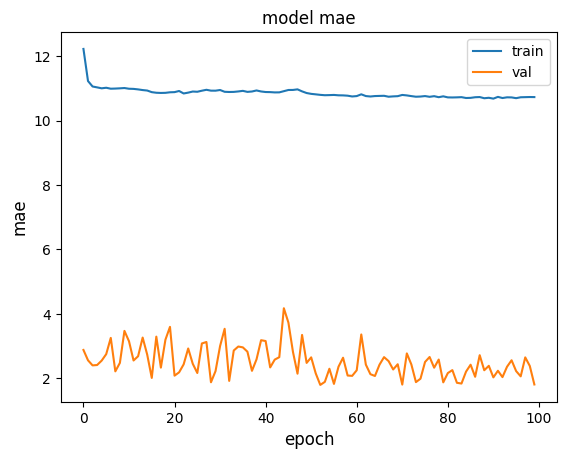

In [29]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [30]:
predictions = model.predict(x_test)

2874/2874 [==============================] - 12s 4ms/step


In [31]:
predictions.shape

(91944, 2, 2)

Visualize some few predictions


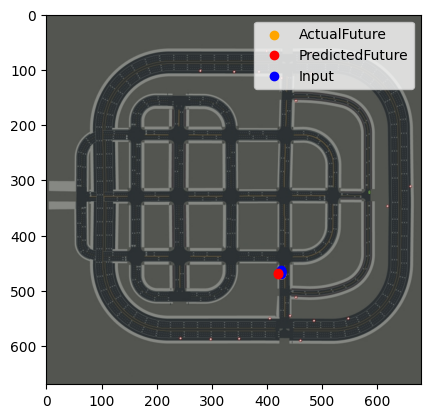

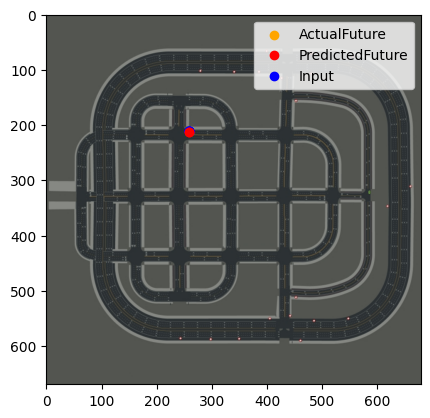

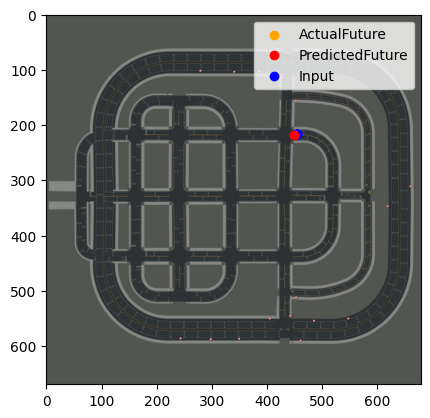

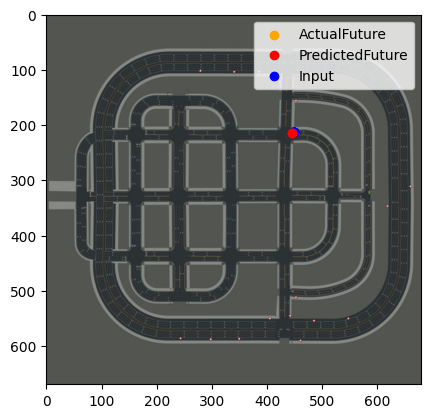

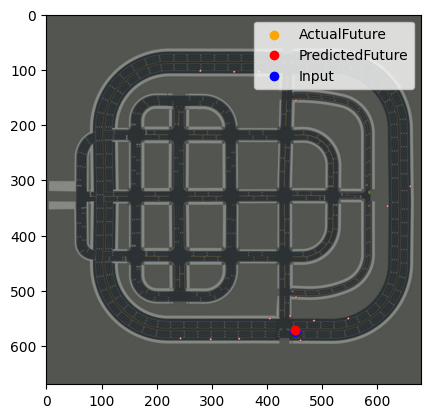

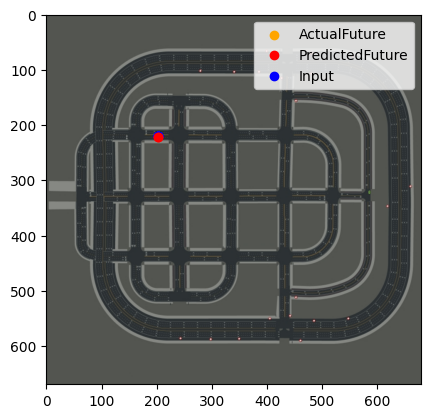

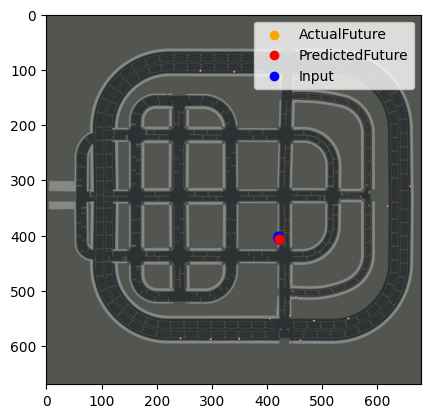

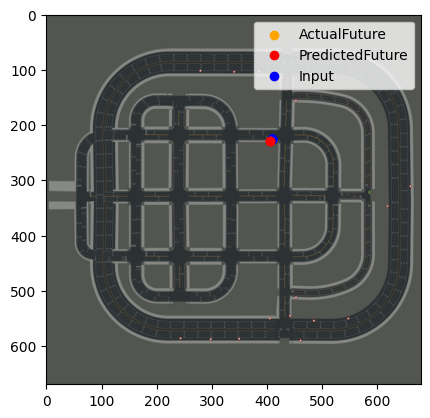

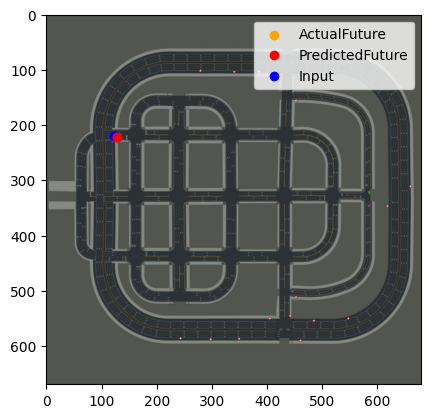

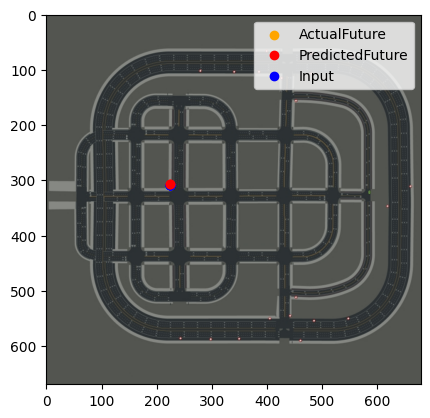

In [32]:
import random
from configs.utils_2 import plot_pred, plot_pred2


print("Visualize some few predictions")

# After finding the best prediction, visualize it
if x_test is not None and y_test is not None and predictions is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(x_test[:, :, :2]))
        plot_pred2(x_test[:, :, :2][index], y_test[index], predictions[index])

## Explainer

In [33]:
from explainers.explainer import BlackBoxWrapper, ITPFExplainer

blackbox = BlackBoxWrapper(model=model, isMultivariate=True)
explainer = ITPFExplainer()
explainer.fit_exp(model=blackbox, x=x_train, y=y_train, feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], class_names=['pos.x', 'pos.y'])

### LIME

In [34]:
explainer.lime(y=x_test[0], labelId=0)

(5000, 8, 8)
157/157 [==============================] - 1s 4ms/step


ValueError: Your model outputs arrays with 3 dimensions

### Shap

In [35]:
explainer.shap(x_test[0])

1/1 [==============================] - 0s 240ms/step


  0%|          | 0/8 [00:00<?, ?it/s]

32/32 [==============================] - 0s 5ms/step


ValueError: cannot reshape array of size 4032 into shape (1008,2)